In [29]:
# Importing the required libraries
import re, collections, os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

import tqdm


---
---
# Token 

In [2]:
class Tokenizer():
    """ This class is used to tokenize the input text and create a vocabulary of tokens. """
    def __init__(self, text, num_merges):
        self.text = text
        self.num_merges = num_merges

    def initialize_vocabulary(self,text):
        """ Initialize the vocabulary from the input text. """
        vocab = collections.defaultdict(int)
        words = text.strip().split()
        for word in words:
            vocab[' '.join(list(word)) + ' '] += 1
        return vocab
    
    def get_tokens_and_frequencies(self,vocab):
        """ Get the tokens and how often they occur in the vocabulary. """
        tokens = collections.defaultdict(int)
        for word, freq in vocab.items():
            word_tokens = word.split()
            for token in word_tokens:
                tokens[token] += freq
        return tokens
    
    def get_pairs_and_counts(self,vocab):
        """ Get the pairs of tokens and how often they occur in the vocabulary. """
        pairs = collections.defaultdict(int)
        for word, freq in vocab.items():
            symbols = word.split()
            for i in range(len(symbols)-1):
                pairs[symbols[i],symbols[i+1]] += freq
        return pairs
    
    def merge_pair_in_vocabulary(self,pair, vocab_in):
        """ Merge the most frequent pair of tokens in the vocabulary. """
        vocab_out = {}
        bigram = re.escape(' '.join(pair))
        p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
        for word in vocab_in:
            word_out = p.sub(''.join(pair), word)
            vocab_out[word_out] = vocab_in[word]
        return vocab_out
    
    def tokenize(self):
        """ Tokenize the input text. """
        if os.path.exists('./data/tokens_{}merges.pt'.format(self.num_merges)):
            print("Loading tokenized data from file")
            tokens = torch.load('./data/tokens_{}merges.pt'.format(self.num_merges),weights_only=False)
            vocab = torch.load('./data/vocab_{}merges.pt'.format(self.num_merges),weights_only=False)
            return tokens, vocab
        
        # Initialize the vocabulary from the input text
        vocab = self.initialize_vocabulary(self.text)

        # Merge the most frequent pair of tokens num_merges times
        with tqdm.tqdm(range(self.num_merges), position=0, leave=True) as pbar:
            for i in pbar:
                tokens = self.get_tokens_and_frequencies(vocab)
                pairs = self.get_pairs_and_counts(vocab)
                if not pairs:
                    break
                most_frequent_pair = max(pairs, key=pairs.get)
                vocab = self.merge_pair_in_vocabulary(most_frequent_pair, vocab)
                pbar.set_description(f'Num merges: {i + 1}')

        # Find the tokens and how often they occur in the vocabulary one last time
        tokens = self.get_tokens_and_frequencies(vocab)

        tokens[' '] = self.text.count(' ')
        tokens['\n'] = self.text.count('\n')

        torch.save(tokens, './data/tokens_{}merges.pt'.format(self.num_merges))
        torch.save(vocab, './data/vocab_{}merges.pt'.format(self.num_merges))

        return tokens, vocab


    def tokenize_text(self, tokens):
        """ Tokenize the input text using the tokens. """
        # Load tokenized data if it exists
        if os.path.exists('./data/tokenized_{}merges.pt'.format(self.num_merges)):
            print("Loading tokenized data from file")
            tokenized_text = torch.load('./data/tokenized_{}merges.pt'.format(self.num_merges),weights_only=False)
            return tokenized_text

        token_list = list(tokens.keys())
        tokenized_text = []  # List to store the tokenized text
        i = 0  # Index to keep track of the current position in the text

        print("Nombre de tokens trouvés :", len(token_list))

        with tqdm.tqdm(total=len(self.text), position=0, leave=True) as pbar:
            pbar.set_description("Tokenizing text")
            while i < len(self.text):
                match = None
                # loop through the tokens to find the longest match
                for token in sorted(token_list, key=len, reverse=True):
                    if self.text[i:i+len(token)] == token: 
                        match = token
                        break
                    
                if match:  
                    tokenized_text.append(match)
                    i += len(match)  # Move the index to the end of the token
                    pbar.update(len(match))
                else:
                    print("Token non trouvé pour le texte restant :", self.text[i:])
                    break 

        # Save the tokenized text
        torch.save(tokenized_text, './data/tokenized_{}merges.pt'.format(self.num_merges))
        return tokenized_text 

In [3]:
data = open('./data/Shakespeare.txt', 'r').read()

In [4]:
tokenizer = Tokenizer(data, 1000)
tokens, vocab = tokenizer.tokenize()
tokenized_text = tokenizer.tokenize_text(tokens)

Loading tokenized data from file
Loading tokenized data from file


In [5]:
print(tokenized_text[:100])

['First', ' ', 'Citizen:', '\n', 'Be', 'fore', ' ', 'we', ' ', 'pro', 'ce', 'ed', ' ', 'any', ' ', 'f', 'ur', 'ther', ',', ' ', 'hear', ' ', 'me', ' ', 'speak', '.', '\n', '\n', 'All', ':', '\n', 'S', 'pe', 'ak', ',', ' ', 'speak', '.', '\n', '\n', 'First', ' ', 'Citizen:', '\n', 'You', ' ', 'are', ' ', 'all', ' ', 'res', 'ol', 'ved', ' ', 'ra', 'ther', ' ', 'to', ' ', 'die', ' ', 'than', ' ', 'to', ' ', 'fa', 'mis', 'h', '?', '\n', '\n', 'All', ':', '\n', 'R', 'es', 'ol', 'ved', '.', ' ', 'res', 'ol', 'ved', '.', '\n', '\n', 'First', ' ', 'Citizen:', '\n', 'First', ',', ' ', 'you', ' ', 'know', ' ', 'C', 'a', 'i']


---
---
# CharDataset

In [18]:
class CharDataset(Dataset):
    """ This class is used to create a PyTorch dataset from the tokenized text. """
    def __init__(self, tokenized_text, tokens, block_size = 64):

        chars = list(tokens.keys())

        self.stoi = {ch: i for i, ch in enumerate(chars)}
        self.itos = {i: ch for i, ch in enumerate(chars)}

        self.dataset = torch.tensor([self.stoi[ch] for ch in tokenized_text], dtype=torch.long)
        self.set_data_mode()

        
        self.vocab_size = len(chars)
        self.block_size = block_size


    def __len__(self):
        """ Return the number of blocks in the dataset, used by the DataLoader. """



        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        """ Return the input and target sequence. """
        chunk = self.data[idx:idx + self.block_size + 1]
        input_chunk = chunk[:-1]
        target = chunk[1:]
        return input_chunk, target

    def get_vocab_size(self):
        """ Return the size of the vocabulary. """
        return self.vocab_size

    def get_stoi(self):
        return self.stoi

    def get_itos(self):
        return self.itos
    
    def set_data_mode(self, train_mode = True):
        train_len = int(10/11 * len(self.dataset))

        if train_mode:
            self.data = self.dataset[:train_len]
        else:
            self.data = self.dataset[train_len:]

        


In [ ]:
dataset = CharDataset(tokenized_text, tokens)

In [ ]:
len(dataset.data)

520780

In [21]:
dataset.set_data_mode(train_mode = False)
len(dataset.data)

52078

---
---
# Positional Encoding


$$(sin(\theta), cos(\theta)) $$ 
where 
$$\theta = \frac{t}{r^k},r = N^{2/d} $$

In [25]:
class PositionalEncoding(nn.Module):
    """ This class is used to add positional encoding to the input embeddings. """
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()

        r = max_len**(2/d_model) * torch.ones(d_model)
        div_term = torch.pow(r, torch.floor(torch.arange(0,d_model)/2))

        self.encoding[:, 0::2] = torch.sin(position * div_term[0::2])
        self.encoding[:, 1::2] = torch.cos(position * div_term[1::2])
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1)].detach()

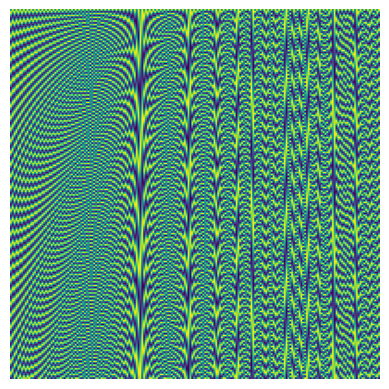

In [47]:
P = PositionalEncoding(200, max_len=200)
x = torch.zeros(1,200, 200)
x = P(x)

plt.axis('off')
plt.imshow(P.encoding.squeeze(0))
plt.show()


---
---
# Attention

In [ ]:
class CausalSelfAttention(nn.Module):
    def __init__(self, n_embd, n_head,n_red, dropout):
        super().__init__()
        self.test = n_red
        self.n_head = n_head
        self.key = nn.Linear(n_embd, n_embd // self.test)
        self.query = nn.Linear(n_embd, n_embd // self.test)
        self.value = nn.Linear(n_embd, n_embd)
        #self.proj = nn.Linear(n_embd, n_embd) # Je ne suis pas sûr de cette ligne

        self.attn_drop = nn.Dropout(dropout)  # Will be used to help model not focusng on a specific token during training
        self.resid_drop = nn.Dropout(dropout)

        self.register_buffer("mask", torch.tril(torch.ones(1024, 1024)).view(1, 1, 1024, 1024))

    def forward(self, x):
        B, T, C = x.size()

        q, k, v = self.query(x), self.key(x), self.value(x)

        # 
        q = q.view(B, T, self.n_head, C // (self.test*self.n_head)).transpose(1, 2)
        k = k.view(B, T, self.n_head, C // (self.test*self.n_head)).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        
        att = (q @ k.transpose(-2, -1)) * (1.0 / (k.size(-1) ** 0.5))
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))
        att = nn.functional.softmax(att, dim=-1)
        att = self.attn_drop(att) 
        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_drop(y)
        return y